<a href="https://colab.research.google.com/github/petrhanulik/pandas_project/blob/pracovni/projekt__ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
!pip install pymysql
import seaborn as sns
import sqlalchemy
conn_string="mysql+pymysql://student:p7@vw7MCatmnKjy7@data.engeto.com/data"
alchemy_conn=sqlalchemy.create_engine(conn_string)
plt.style.use("fivethirtyeight")

Nactu tabulku a seznamim se s ni (kolik ma radku, sloupcu, jsou datumy ve formatu Datetime, jaky je rozsah tabulky)

In [4]:
kola = pd.read_sql("edinburgh_bikes", alchemy_conn)
kola.info()
print(kola[['started_at']].min())
print(kola[['started_at']].max())
kola['started_at'].max()- kola['started_at'].min()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340986 entries, 0 to 340985
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   index                      340986 non-null  int64         
 1   started_at                 340986 non-null  datetime64[ns]
 2   ended_at                   340986 non-null  datetime64[ns]
 3   duration                   340986 non-null  int64         
 4   start_station_id           340986 non-null  int64         
 5   start_station_name         340986 non-null  object        
 6   start_station_description  338612 non-null  object        
 7   start_station_latitude     340986 non-null  float64       
 8   start_station_longitude    340986 non-null  float64       
 9   end_station_id             340986 non-null  int64         
 10  end_station_name           340986 non-null  object        
 11  end_station_description    338426 non-null  object  

Timedelta('776 days 14:59:20')

**Posouzeni aktivnich x neaktivnich stanic**

In [5]:
# tabulku upravim, nastavim index
df = kola.copy()
df = df.sort_values(['started_at'])
df['start_station_name_control'] = df['start_station_name']
df.set_index('start_station_name', inplace=True)
# spocitam prum. cas mezi vypujckami ve stejnych stanicich a mnozstvi vypujcek
df['started_at_shifted'] = df.groupby(level=0)['started_at'].shift(-1) 
df['cas_mezi_vypujckama'] = df['started_at_shifted'] - df['started_at']
df_prumer_mezi_vypujckama = df.groupby('start_station_name_control')['cas_mezi_vypujckama'].apply(np.mean).reset_index()
vyskyt_stanic = df.groupby(df.index)[['start_station_name_control']].count()
vyskyt_stanic = vyskyt_stanic.sort_values('start_station_name_control' ,ascending=False)
df_prumer_mezi_vypujckama['prum_v_min'] = df_prumer_mezi_vypujckama[['cas_mezi_vypujckama']].apply(lambda x: x/np.timedelta64(1,'m')).fillna(0).astype('int32')
df_prumer_mezi_vypujckama.set_index('start_station_name_control', inplace=True)
popis_stanic = df_prumer_mezi_vypujckama.join(vyskyt_stanic)
popis_stanic.columns = ['cas_mezi_vypujckama', 'prum_v_min', 'pocet_vypujcek']
popis_stanic = popis_stanic.sort_values('pocet_vypujcek', ascending=False)

In [6]:
popis_stanic

,cas_mezi_vypujckama,prum_v_min,pocet_vypujcek
start_station_name_control,,,
Meadows East,0 days 01:27:49.514393581,87,12715
Bristo Square,0 days 01:41:24.037279505,101,10999
St Andrew Square,0 days 01:47:48.667148780,107,10372
Meadow Place,0 days 01:54:04.307816649,114,8662
Victoria Quay,0 days 02:17:01.583732645,137,8140
...,...,...,...
Pleasance - Edinburgh University Sports Fair,0 days 00:32:19,32,2
Royal Highland Show - West Gate (19th to 23rd June),NaT,0,1
Cycling Scotland Conference,NaT,0,1


nektivni stanice jsou na konci tabulky

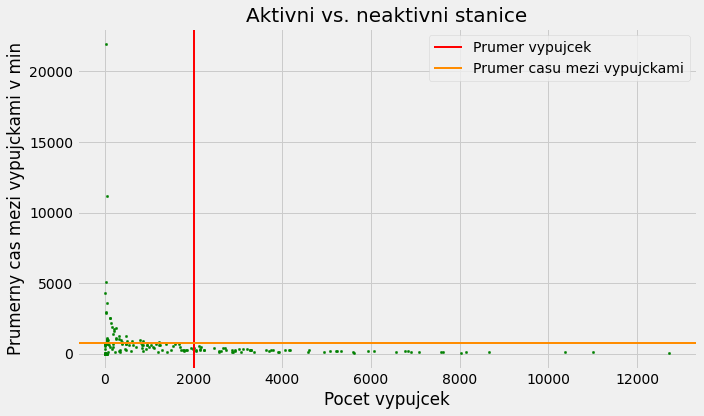

In [7]:
# spoctu prumer mezi vypujckami za vsechny stanice, take prumerny pocet vypujcek 
prumer_mezi_vypujckami = popis_stanic['prum_v_min'].mean()
prumer_poctu_vypujcek = popis_stanic['pocet_vypujcek'].mean()
mnozstvi_vypujcek = popis_stanic['pocet_vypujcek']
prumerny_cas_mezi_vypujckami = popis_stanic['prum_v_min']
# zobrazim graficky situaci prumernych casu a prumernych mnozstvi vypujcek
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(mnozstvi_vypujcek, prumerny_cas_mezi_vypujckami, c='g', s=5)

ax.axvline(prumer_poctu_vypujcek, color='red', linewidth=2, label='Prumer vypujcek')
ax.axhline(prumer_mezi_vypujckami, color='darkorange', linewidth=2, label='Prumer casu mezi vypujckami')
ax.legend()
ax.set_title("Aktivni vs. neaktivni stanice", fontsize=20)
ax.set_xlabel("Pocet vypujcek")
ax.set_ylabel("Prumerny cas mezi vypujckami v min")

plt.tight_layout()

"okometricky" neaktivni budou mit relativne malo vypujcek, pripadne dlouhe casy mezi vypujckami, jinak receno budou lezet spis vys od osy x  a dosti blizko k ose y

**Nejfrekventovanejsi stanice**

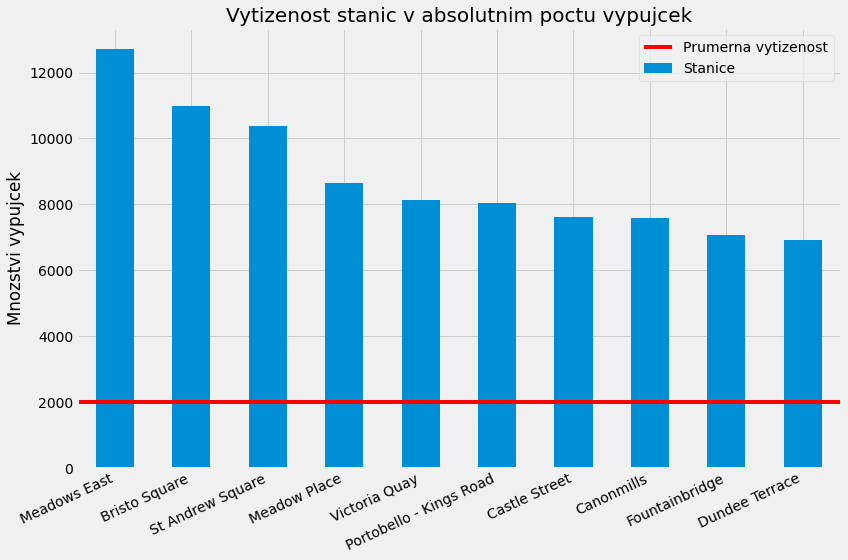

In [8]:
# nastavim index, urcim prumerny pocet vypujcek za vsechny stanice, pocet vypujcek v jednotlivych stanicich
nejfrekventovanejsi = kola.copy()
nejfrekventovanejsi['start_station_name_control'] = nejfrekventovanejsi[['start_station_name']]
nejfrekventovanejsi.set_index('start_station_name', inplace=True)
prum_nejfrekventovanejsich = nejfrekventovanejsi[['start_station_name_control']].value_counts().mean()
nejfrekventovanejsi = nejfrekventovanejsi['start_station_name_control'].value_counts()
nejfrekventovanejsi = nejfrekventovanejsi[0:10]
# zobrazim v grafu prvnich deset nejvytizenejsich
fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot2grid((1,1), (0,0), fig=fig)

nejfrekventovanejsi.plot.bar(ax=ax1, label='Stanice')
plt.axhline(prum_nejfrekventovanejsich, color='red', label='Prumerna vytizenost')
plt.legend()

ax1.set_title('Vytizenost stanic v absolutnim poctu vypujcek', size=20)
ax1.set_xticklabels(nejfrekventovanejsi.index, rotation=25, ha='right')
ax1.set_ylabel('Mnozstvi vypujcek')
plt.tight_layout()

**Kde se kola hromadi, kde je nedostatek**

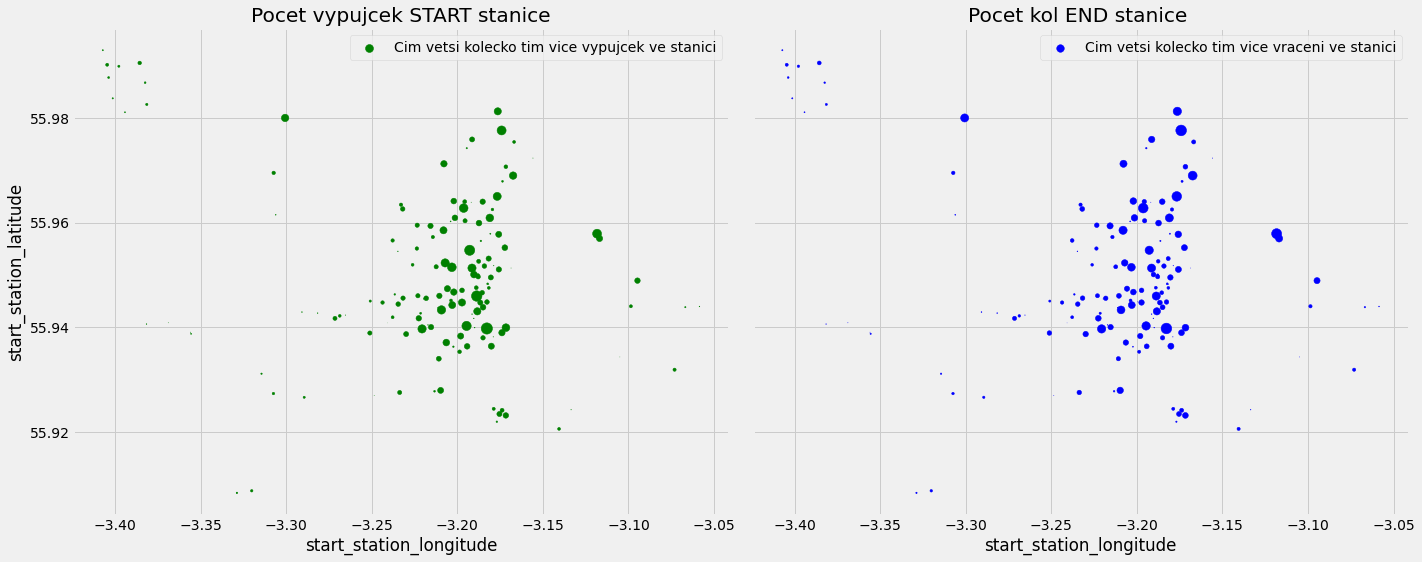

In [9]:
# uprava pocatecnich stanic
df = kola.copy()
df['start_station_name_control'] = df[['start_station_name']]
df.set_index('start_station_name', inplace=True)
df['pocet_vypujcek_start'] = df['start_station_name_control'].value_counts()
df = df.drop_duplicates('start_station_name_control')
df = df.sort_values('pocet_vypujcek_start', ascending=False)
# uprava koncovych stanic
df2 = kola.copy()
df2['end_station_name_control'] = df2[['end_station_name']]
df2.set_index('end_station_name', inplace=True)
df2['pocet_vypujcek_end'] = df2['end_station_name_control'].value_counts()
df2 = df2.drop_duplicates('end_station_name_control')
# v datasetu mam jednu odlehlou hodnotu, najdu ji a dropnu, kazi mi totiz scatter graf
df2[df2['end_station_longitude'] >= -3]
df2 = df2.drop('Smarter Travel Station')
df2 = df2.sort_values('pocet_vypujcek_end', ascending=False)
# udelam join chci mit pocty ve stanicich start a end vedle sebe
df2 = df2[['pocet_vypujcek_end']]
df = df.join(df2)
# situaci zobrazim v grafech 
fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((2,2), (0,0), fig=fig)
ax2 = plt.subplot2grid((2,2), (0,1), fig=fig, sharey=ax1)

df.plot.scatter('start_station_longitude', 'start_station_latitude', ax=ax1,
                s=df['pocet_vypujcek_start']/100,
                color='green', label='Cim vetsi kolecko tim vice vypujcek ve stanici')
df.plot.scatter('start_station_longitude', 'start_station_latitude', ax=ax2,
                s=df['pocet_vypujcek_end']/100,
                color='blue', label='Cim vetsi kolecko tim vice vraceni ve stanici')

plt.legend()

ax1.set_title('Pocet vypujcek START stanice')
ax2.set_title('Pocet kol END stanice ')

plt.tight_layout()

Kola se hromadi trochu vic ve stanicich lezicich smerem k pravemu hornimu rohu grafu "POCET KOL END STANICE" kdyz se podivam na google mapy tim smerem lezi more, vyrazne rozdily nejsou patrne

**Vzdalenosti mezi stanicemi**

In [15]:
# pocitam vzdalenosti mezi stanicemi
from geopy import distance
vzdalenosti = kola.copy()
vzdalenosti['od/do'] = vzdalenosti.apply(lambda x: '{0}/{1}'.format(x['start_station_name'], x['end_station_name']),axis=1)
vzdalenosti = vzdalenosti[['od/do', 'start_station_latitude', 'start_station_longitude', 'end_station_name', 'end_station_latitude', 'end_station_longitude' ]].drop_duplicates()
vzdalenosti['vzdalenost_od_do'] = vzdalenosti.apply(lambda x: distance.distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])).km, 1)
vzdalenosti = vzdalenosti[vzdalenosti['vzdalenost_od_do'] != 0]
vzdalenosti['vzdalenost_od_do'] = round(vzdalenosti['vzdalenost_od_do'],2)

In [16]:
# pocitam min. vzdalenost
minimum = vzdalenosti['vzdalenost_od_do'].min()
stanice_min = vzdalenosti[vzdalenosti['vzdalenost_od_do'] == minimum]
stanice_min

,od/do,start_station_latitude,start_station_longitude,end_station_name,end_station_latitude,end_station_longitude,vzdalenost_od_do
40958,Pollock Halls/Pollock Halls Virtual,55.939963,-3.171586,Pollock Halls Virtual,55.940348,-3.172108,0.05
44305,Pollock Halls Virtual/Pollock Halls,55.940348,-3.172108,Pollock Halls,55.939963,-3.171586,0.05


In [17]:
# pocitam max. vzdalenost
maximum = vzdalenosti['vzdalenost_od_do'].max()
stanice_max = vzdalenosti[vzdalenosti['vzdalenost_od_do'] == maximum]
stanice_max

,od/do,start_station_latitude,start_station_longitude,end_station_name,end_station_latitude,end_station_longitude,vzdalenost_od_do
27013,Macdonald Road/Smarter Travel Station,55.963995,-3.185189,Smarter Travel Station,53.395525,-2.990138,286.19


In [18]:
# chci je mit v jednom Dataframu pod sebou
vzdalenosti = vzdalenosti.loc[[40958, 27013], :]
vzdalenosti.set_index('od/do', inplace=True)
vzdalenosti_start = vzdalenosti[['start_station_longitude', 'start_station_latitude']]
vzdalenosti_end = vzdalenosti[['end_station_name','end_station_longitude', 'end_station_latitude']].reset_index().drop('od/do',1).set_index('end_station_name')

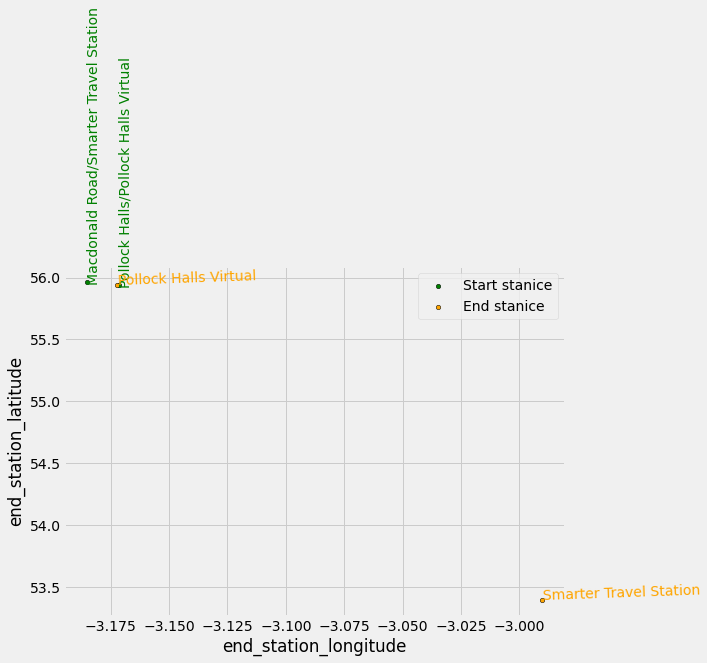

In [19]:
# pro predstavu zobrazim graficky nejblizsi a nevzdalenejsi stanice
fig, ax = plt.subplots()
vzdalenosti_start.plot.scatter('start_station_longitude', 'start_station_latitude',
                               ax=ax, figsize=(8,6), edgecolor='black', color='green', label='Start stanice')

for i, oddo in enumerate(vzdalenosti_start.index):
    ax.text(vzdalenosti_start.iloc[i,0], vzdalenosti_start.iloc[i,1], oddo, rotation=90, color='g')

vzdalenosti_end.plot.scatter('end_station_longitude', 'end_station_latitude',
                             ax=ax,  edgecolor='black', color='orange', label='End stanice')

for i, oddo in enumerate(vzdalenosti_end.index):
    ax.text(vzdalenosti_end.iloc[i,0], vzdalenosti_end.iloc[i,1], oddo, rotation=2, color='orange')  

### **Jak dlouho trvá jedna výpůjčka?**

In [20]:
# vypoctu, jak v prumeru trva jedna vypujcka, chci ji zobrazit v grafu
doba_vypujcky = kola.copy()
prum_doba_vypujcky = np.round((doba_vypujcky['duration']/60).mean())
# doby vypujcek prepoctu na minuty
doba_vypujcky = round(doba_vypujcky['duration']/60)

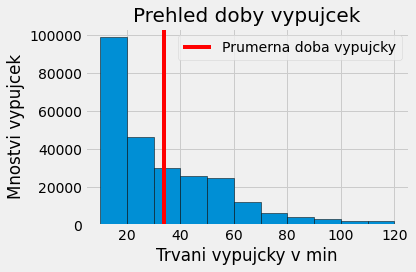

In [21]:
# zobrazim v histogramu
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

plt.hist(doba_vypujcky, bins=bins, edgecolor='black');

prum_doba_vypujcky
color = 'red'

plt.axvline(prum_doba_vypujcky, color='red', label='Prumerna doba vypujcky')
plt.legend()

plt.title('Prehled doby vypujcek', fontsize=20)
plt.xlabel('Trvani vypujcky v min')
plt.ylabel('Mnostvi vypujcek')

plt.tight_layout()

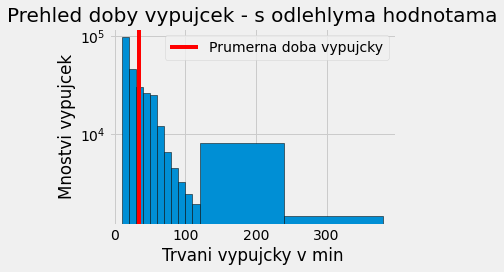

In [22]:
# zobrazuji i odlehlejsi hodnoty a pouziji logaritmicke zobrazeni pro prehlednejsi zobrazeni
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 240, 380]

plt.hist(doba_vypujcky, bins=bins, edgecolor='black', log=True);

prum_doba_vypujcky
color = 'red'

plt.axvline(prum_doba_vypujcky, color='red', label='Prumerna doba vypujcky')
plt.legend()

plt.title('Prehled doby vypujcek - s odlehlyma hodnotama', fontsize=20)
plt.xlabel('Trvani vypujcky v min')
plt.ylabel('Mnostvi vypujcek')

plt.tight_layout()

In [23]:
doba_vypujcky.describe()

count    340986.000000
mean         34.355498
std         145.062174
min           1.000000
25%          10.000000
50%          19.000000
75%          42.000000
max       22884.000000
Name: duration, dtype: float64

Prumerna doby vypujcky trva 34 minut, nejmin trvala vypujcka minutu, nejvic skoro 16 dnu, STD mi rika, ze se doby vypujcek od sebe znacne lisi, cim vyssi std tim vetsi variabilita v souboru dat

### **Vyvoj poptavky po kolech v case**

In [24]:
vyvoj = kola.copy()
# pro dalsi praci se souborem urcim si den v tydnu, hodinu pujceni, mesic
vyvoj['den_v_tydnu'] = vyvoj['started_at'].dt.day_name()
vyvoj['hodina'] = vyvoj['started_at'].dt.hour
vyvoj['mesic'] = vyvoj['started_at'].dt.month
vyvoj['rok'] = vyvoj['started_at'].dt.year
# upravim si index
vyvoj['started_at'] =  vyvoj['started_at'].dt.strftime('%Y-%m-%d')
vyvoj['started_at'] =  pd.to_datetime(vyvoj['started_at'])
vyvoj = vyvoj.assign(pocet = 1)
vyvoj.set_index('started_at', inplace=True)
# spocitam kolik mam vypujcek v jednom dni
vyvoj['vypujcek_za_den'] = vyvoj[['pocet']].groupby(level=0).count()
# spocitam vypujcky jen za vikend - Saturday, Sunday
vyvoj['vikend'] = np.where(vyvoj['den_v_tydnu'].isin(['Saturday', 'Sunday']), vyvoj['vypujcek_za_den'], np.nan)

In [25]:
vypujcek_za_den = vyvoj[['pocet']].groupby(level=0).count()
# roztridim si jednotlivy roky
vypujcky_2018 = vypujcek_za_den['2018-09-15':]
vypujcky_2019 = vypujcek_za_den['2019-01-01':'2019-12-31']
vypujcky_2020 = vypujcek_za_den['2020-01-01':]

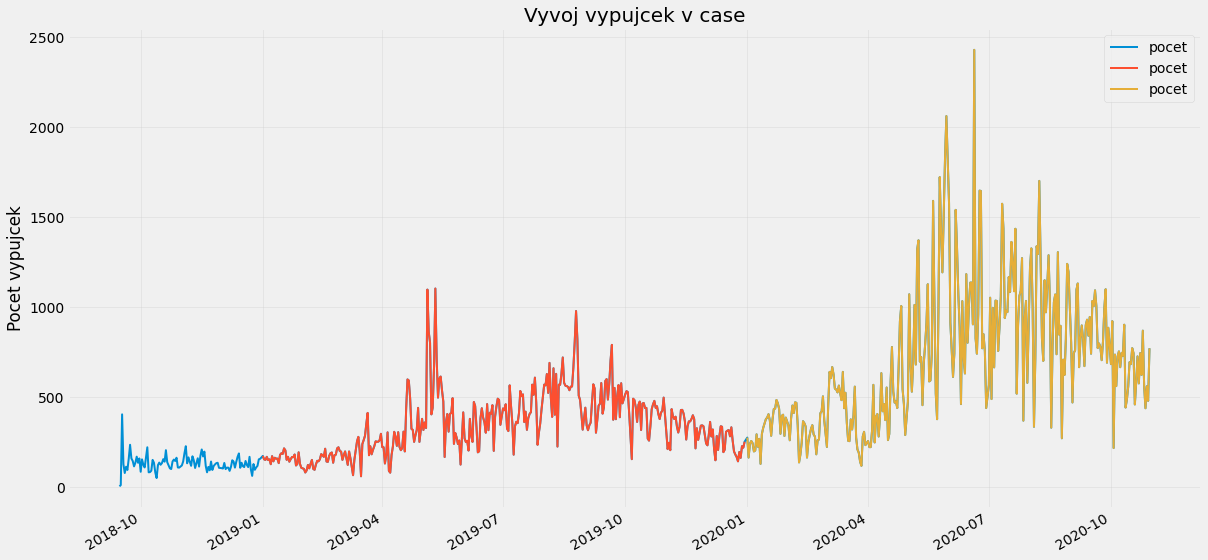

In [26]:
# zobrazim prubeh vyvoje poptavky v case
fig, ax = plt.subplots(figsize=(17,8))
vypujcky_2018.plot(ax=ax, linewidth=2, label='lzu')
vypujcky_2019.plot(ax=ax, linewidth=2)
vypujcky_2020.plot(ax=ax, linewidth=2)
ax.set_ylabel('Pocet vypujcek')
ax.set_xlabel('')
ax.set_title('Vyvoj vypujcek v case', fontsize=20)
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()

Poptavka po kolech se roku 2020 diametralne zvysila oproti predchozim rokum 2018 a 2019

### **Priciny vykyvu poptavky po kolech**

In [27]:
vypujcek_za_den.reset_index(inplace=True)

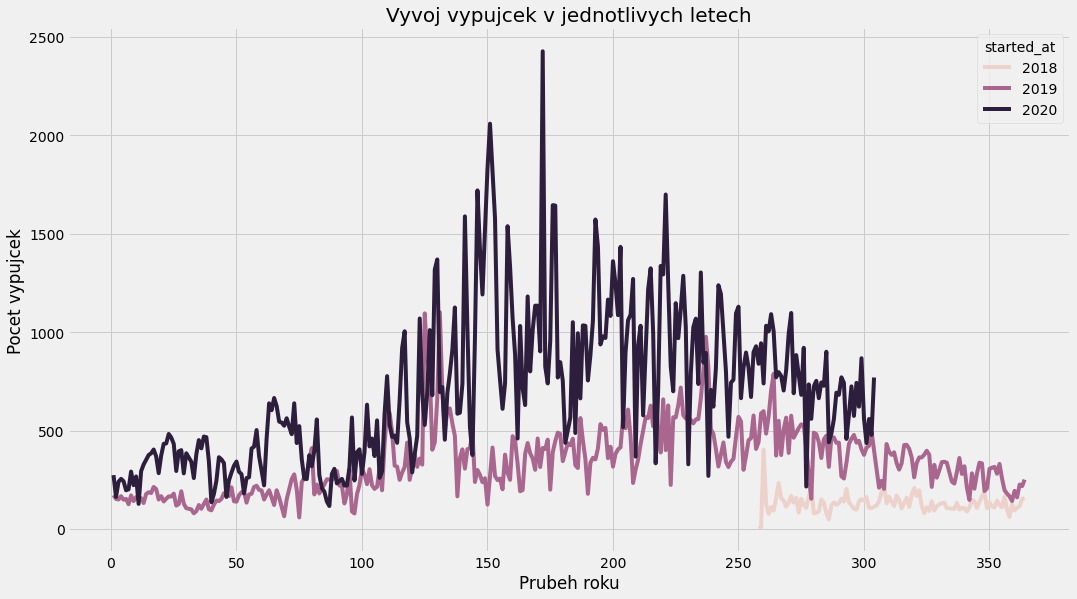

In [28]:
# chci videt, zdali je mozne pohledem rozeznat tredy vypujcek behem roku
fig, ax = plt.subplots(figsize=(16,9))
ax = sns.lineplot(x=vypujcek_za_den['started_at'].dt.dayofyear,
             y=vypujcek_za_den['pocet'],
             hue=vypujcek_za_den['started_at'].dt.year
             )
plt.title('Vyvoj vypujcek v jednotlivych letech', fontsize=20)
ax.set(xlabel='Prubeh roku', ylabel='Pocet vypujcek');

Ve vsech trech letech lze sledovat podobne trendy v poptavce, zacatek roku pozvolny narust, od pozdniho leta pozvolne povadnuti poptavky po kolech

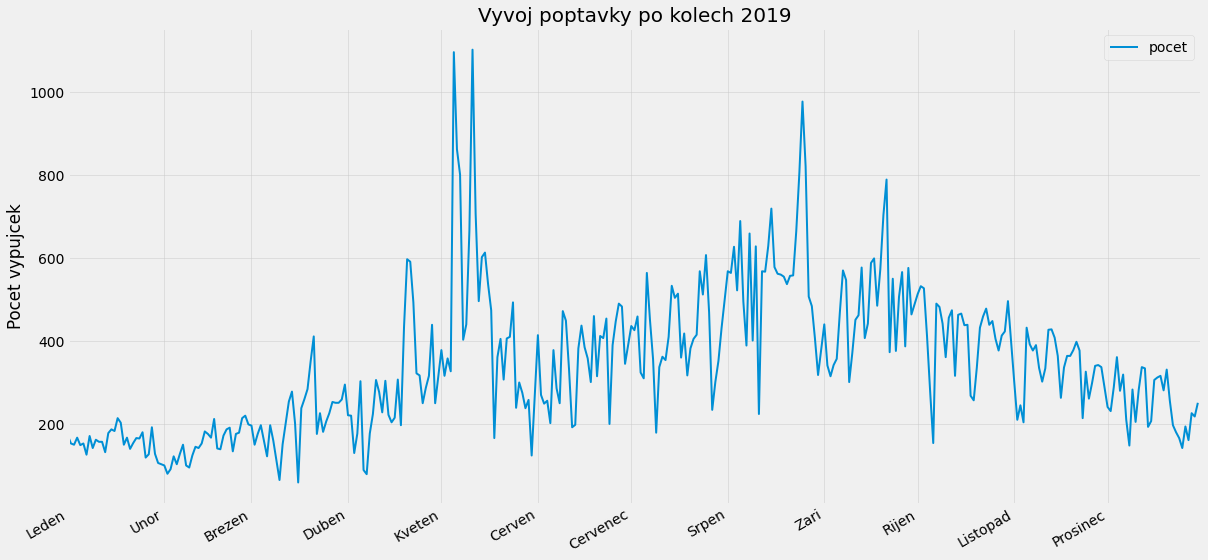

In [29]:
# prubeh vyvoje za cely rok mam jen pro 2019, zobrazim si ho
fig, ax = plt.subplots(figsize=(17,8))
vypujcky_2019.plot(ax=ax, linewidth=2)
ax.set_ylabel('Pocet vypujcek')
ax.set_xlabel('')
ax.set_title('Vyvoj poptavky po kolech 2019', fontsize=20)
plt.xlim('2019-01-01', '2019-12-31')
ax.set_xticklabels(['Leden', 'Unor', 'Brezen', 'Duben', 'Kveten', 'Cerven', 'Cervenec', 'Srpen', 'Zari', 'Rijen', 'Listopad', 'Prosinec'])
ax.grid(alpha=0.5)
ax.legend()
plt.tight_layout()

Pujcovani kol v Edinburgu v roce 2019 je dosti sezonni zalezitosti, nejvice se kola pujcuji v lete, otazkou je co zpusobilo 2 znacne vykyvy v kvetnu?... ten prvni 5. kvetna byl dnem pred Bank holiday, tak si lidi delali vylety, 11. kvetna byly dve akce (Running Event a Detox Health Beauty)

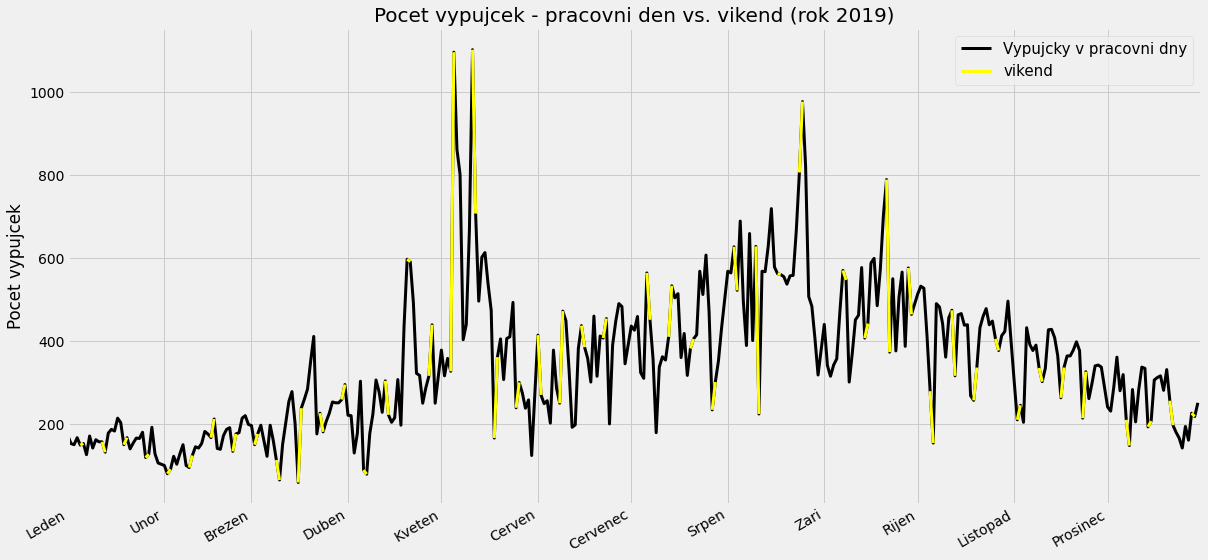

In [30]:
# zajimaji me vykyvy poptavky o vikendech
fig, ax = plt.subplots(figsize=(17,8))
vyvoj[['vikend']].groupby(level=0).size()['2019-01-01':'2019-12-31'].plot(ax=ax, linewidth=3, color='black', label='Vypujcky v pracovni dny')
vyvoj[['vikend']]['2019-01-01':'2019-12-31'].plot(ax=ax, linewidth=3, color='yellow', label='Vypujcky o vikendu')
plt.xlim('2019-01-01', '2019-12-31')
ax.set_xticklabels(['Leden', 'Unor', 'Brezen', 'Duben', 'Kveten', 'Cerven', 'Cervenec', 'Srpen', 'Zari', 'Rijen', 'Listopad', 'Prosinec'])
ax.set_title('Pocet vypujcek - pracovni den vs. vikend (rok 2019)', fontsize=20)
ax.set_ylabel('Pocet vypujcek')
ax.set_xlabel('')
ax.legend(fontsize=15)
plt.tight_layout()

V zimnich a podzimnich mesicich si lide pujcuji kola o vikendu min oproti letnim mesicum

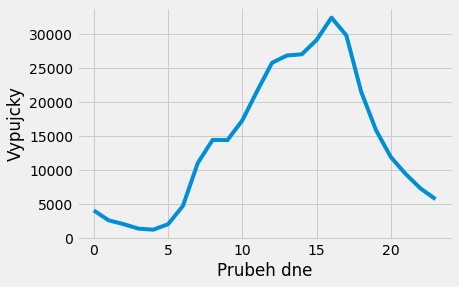

In [31]:
# chci vedet, kdy se kola behem dne poptavaji nejvice
vyvoj.groupby('hodina').size().plot()
plt.xlabel('Prubeh dne')
plt.ylabel('Vypujcky');

Podivame-li se na prubeh poptavky behem dne, nejvice si lide pujcuji kola kolem 4 hodin odpoledne

### **Vliv pocaci na poptavku**

In [32]:
poptavka = kola.copy()
vypujcek_za_den = vypujcek_za_den.copy()
vypujcek_za_den.set_index('started_at', inplace=True)
# nactu si tabulku s udaji o pocasi
pocasi = pd.read_sql("edinburgh_weather", alchemy_conn)
pocasi['date'] = pd.to_datetime(pocasi['date'] )
pocasi.set_index('date', inplace=True)
# nad tabulkou provedu upravy (k dalsi praci si vemu jen pocitovou teplotu a srazky)
pocasi['feels'] = pocasi['feels'].str[0:2].astype(int)
pocasi['rain'] = pocasi['rain'].str[0:3].astype(float)
pocasi = pocasi.resample('D').agg({'feels':'max', 'rain':'sum'}) 
pocasi = pocasi['2018-09-15':'2020-10-30']
df = vypujcek_za_den.join(pocasi)

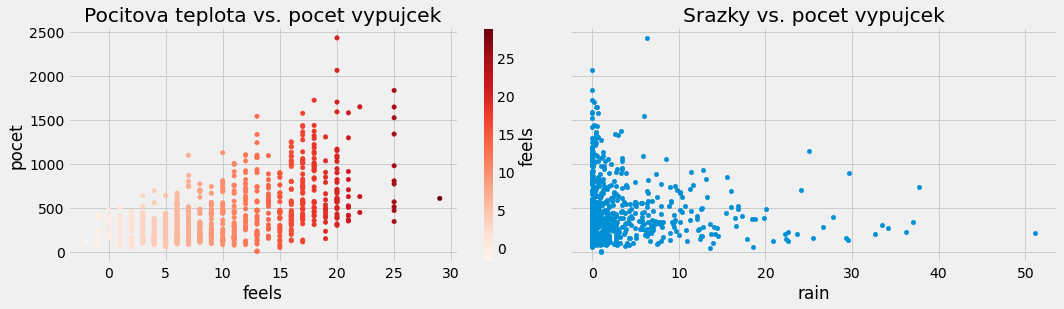

In [35]:
df = df.sort_values('feels').reset_index(drop=True)
df2 = df.sort_values('rain').reset_index(drop=True)

fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid((2,2), (0,0), fig=fig)
ax2 = plt.subplot2grid((2,2), (0,1), fig=fig, sharey=ax1)

df.plot.scatter('feels', 'pocet', ax=ax1, c='feels', cmap='Reds')
df2.plot.scatter('rain', 'pocet', ax=ax2)

fig.set_label('Mira teploty')

ax1.set_title('Pocitova teplota vs. pocet vypujcek')
ax2.set_title('Srazky vs. pocet vypujcek')
plt.tight_layout()

S rostouci teplotou se zvysuje pocet vypujcenych kol (to vsak neznamena zavislost mnostvi vypujcenych kol na teplote). Je videt, ze cim min srazek, tim vice se kola pujcuji (opet tady nepanuje zadna zavislost)

### **Je poptavka po kolech vetsi v pracovni dny ci vikendu?**

In [36]:
# provedu upravy - agregaci v ramci pracovniho tydne vs. vikend
pracovni_tyden = vyvoj.copy()
pracovni_tyden = vyvoj[vyvoj['den_v_tydnu'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
vikend = vyvoj[vyvoj['den_v_tydnu'].isin(['Saturday', 'Sunday'])]
pracovni_tyden_h = pracovni_tyden.groupby('hodina').size()
vikend_h = vikend.groupby('hodina').size()

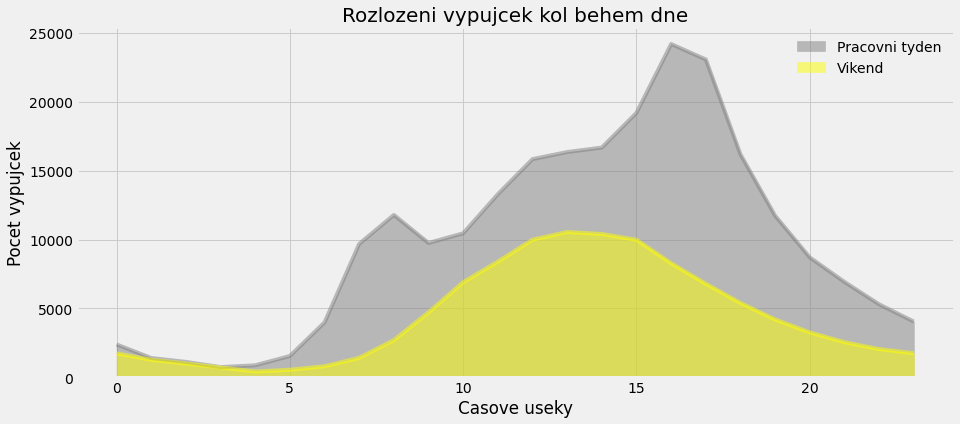

In [37]:
# zobrazim agregovane hodnoty 
pracovni_tyden_h.plot.area(figsize = (14, 6), stacked = False, color = 'grey', label='Pracovni tyden')
vikend_h.plot.area(stacked = False, color = 'yellow', label='Vikend')

plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.title('Rozlozeni vypujcek kol behem dne', fontsize=20)
plt.xlabel('Casove useky')
plt.ylabel('Pocet vypujcek')
plt.legend(loc='upper right', frameon = False);

Je patrne, ze prevlada poptavka v praconi dny oproti vikendum, take rozlozeni poptavky v pracovni tyden je jine, vrchol dopoledne by mohl naznacovat, ze nekteri vyuzivaji kolo k dojizdeni do prace